In [159]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as spint
import sys
sys.path.append("D:/repositories/")
import wopy3.maginv.spectral_tools as spectral_tools
import sys
import os
from pathlib import Path

os.environ['PROJ_LIB'] = r'C:\Users\sungw509\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

import wopy3.func_dump as func_dump
import wopy3.utils as utils
import wopy3.maginv.SH_filter as SH_filter
import wopy3.forward.forward_calculators as forward_calculators

import scipy.spatial as spatial
import scipy.interpolate as interpolate
from mpl_toolkits.basemap import Basemap
import pyshtools as pysh

import multiprocessing
import equivalent_layer_model_v1 as equi
import equivalent_layer_cartesian as equi_cart

import time
%config Completer.use_jedi = False

import datetime

plt.style.use('tableau-colorblind10')

In [711]:
worldmap = Basemap(projection='laea',width=500000,height=500000,lat_0=67.5,lon_0=-45)
#worldmap.drawcoastlines()

corners = worldmap.llcrnrx,worldmap.urcrnrx,worldmap.llcrnry,worldmap.urcrnry

with open('merged_database.XYZ') as f:
    print(f.readline())


2011/03/16,-94.5698,81.442695,5348.18,-92.40,56676.36,-67.96,88.41



In [712]:
data_selection = 'year'

aeromag = np.loadtxt('merged_database.XYZ',delimiter=',',usecols=np.arange(1,8,dtype=int))
with open('merged_database.XYZ') as f:
    lines = f.readlines()
years = []
for line in lines:
    date = line.split(',')[0]
    year,month,day = list(map(int,date.split('/')))
    years.append(year)
years = np.array(years)
if data_selection == 'random':
    # Reduce size to 10 % using random selection
    subset = np.random.choice(len(aeromag),len(aeromag)//10,replace=False)
elif data_selection == 'year':
    subset = years < 1997

aeromag = aeromag[subset]
x,y = worldmap(aeromag[:,0],aeromag[:,1])
in_map = (x >= corners[0]) & (x <= corners[1]) & (y >= corners[2]) & (y <= corners[3]) 
aeromag = aeromag[in_map]
years = years[subset][in_map]
print(in_map.sum())

32265


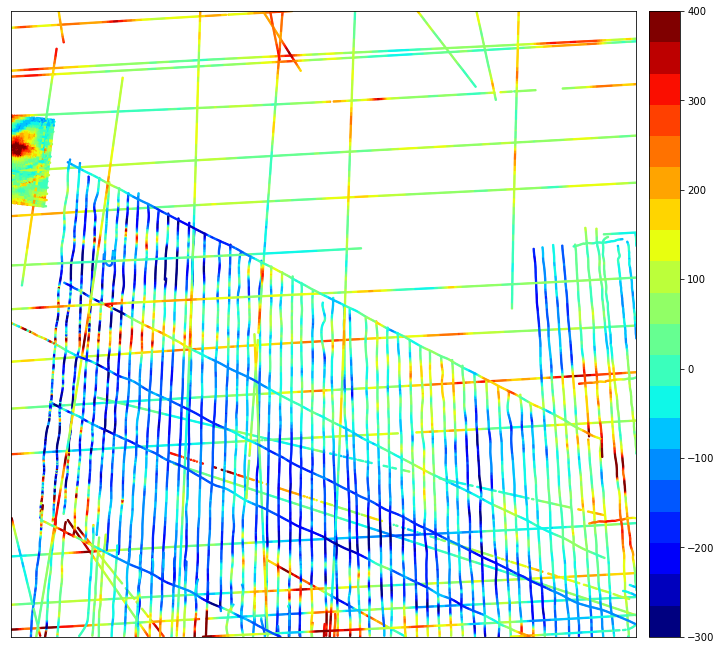

In [713]:
xsi,ysi = worldmap(aeromag[:,0],aeromag[:,1])
plt.figure(figsize=(12,12))
worldmap.scatter(xsi,ysi,2,aeromag[:,3],cmap=plt.cm.get_cmap("jet",20),vmin=-300,vmax=400)
worldmap.colorbar()

In [714]:
dipole_spacing = 1000
dipole_depth = 1000
aux_spacing = 5000
aux_height = 0

xdp = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+dipole_spacing,dipole_spacing)
ydp = np.arange(worldmap.llcrnry,worldmap.urcrnry+dipole_spacing,dipole_spacing)

xi,yi = np.meshgrid(xdp,ydp)
lonp,latp = worldmap(xi,yi,inverse=True)

dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

xa = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+aux_spacing,aux_spacing)
ya = np.arange(worldmap.llcrnry,worldmap.urcrnry+aux_spacing,aux_spacing)

xi,yi = np.meshgrid(xa,ya)
lona,lata = worldmap(xi,yi,inverse=True)

auxiliary = np.vstack((lona.flatten(),lata.flatten(),aux_height*np.ones(lona.size))).T

igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
order = [1,2,0]
# Note: pyshtools uses rad,theta,phi
# Here I change to NED system
igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
igrf_NED_dip = igrf_NED_dip[:,order]

igrf_NED_aux = igrf_coeffs.expand(lon=lona.flatten(),lat=lata.flatten(),a=6371.2+aux_height*0.001)
igrf_NED_aux[:,0] = - igrf_NED_aux[:,0]
igrf_NED_aux[:,1] = - igrf_NED_aux[:,1]
igrf_NED_aux = igrf_NED_aux[:,order]

igrf_NED_stat = np.squeeze(equi.igrf_comp(aeromag[:,5],aeromag[:,6],aeromag[:,4]))

## Synthetic tests for size of far field effects 

In [6]:
# Visualize sensitivity to example dipole
fake_height = 1000
centre = np.zeros((1,3))
results = []
depth_vals = [0,1e3,2e3,5e3,10e3,20e3,50e3]

lon_ax = np.arange(-55,-35,0.01)[:-1]
lat_ax = np.arange(60,65,0.01)[:-1]
loni,lati = np.meshgrid(lon_ax,lat_ax)
fake_aeromag = np.vstack((loni.flatten(),lati.flatten(),np.ones(loni.size)*fake_height)).T
fake_igrf = np.zeros(fake_aeromag.shape)
fake_igrf[:,2] = 5e4

for depth_sel in depth_vals:

    centre[0] = lonp.mean(),latp.mean(),-depth_sel
    centre_igrf = np.zeros((1,3))

    centre_igrf[0] = 0,0,5e4
    results.append(equi.calculate_ano_design_matrix(fake_aeromag,centre,fake_igrf,centre_igrf))

dist = func_dump.get_all_geo_distance(fake_aeromag[:,0],fake_aeromag[:,1],centre[0,0],centre[0,1])
results = np.squeeze(np.array(results))
results_norm = results/(results).max(1)[:,None]
ix = np.argsort(dist)

(0.0, 100.0)

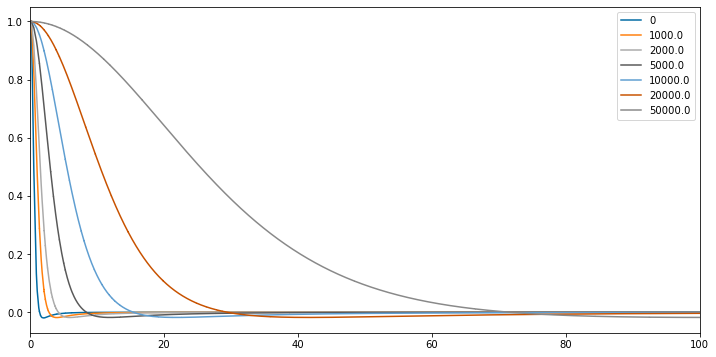

In [7]:
plt.figure(figsize=(12,6))
plt.plot(110.0*dist[ix],results_norm.T[ix])
plt.legend(depth_vals)
plt.xlim([0,100])

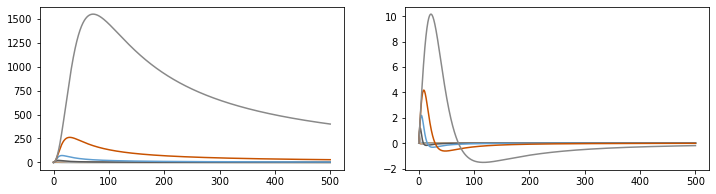

In [8]:
# Interpolate to a regular dist interval
d_ax = np.linspace(0,500,2001)
results_interp = interpolate.interp1d(110.0*dist[ix],results_norm.T[ix],axis=0,bounds_error=False)(d_ax)
results_interp[np.isnan(results_interp)] = 0.0
A = np.pi * d_ax * (d_ax[1]-d_ax[0])
results_cum = np.cumsum(A[:,None]*results_interp,axis=0)
fig,axs = plt.subplots(1,2,figsize=(12,3))
axs[0].plot(d_ax,results_cum)
#axs[0].set_xlim([0,100])
axs[1].plot(d_ax,results_interp*A[:,None])
#axs[1].set_xlim([0,100])


In [9]:
def generate_from_power_2d_alt(Nx,Ny,Lx,Ly,P_func,remove_inf=True,repetitions=1):
    x = np.linspace(0,Lx,Nx+1)
    y = np.linspace(0,Ly,Ny+1)
    xi,yi = np.meshgrid(x[:-1],y[:-1])

    kx = 2.0*np.pi*np.fft.fftshift(np.fft.fftfreq(Nx,x[1]-x[0]))
    ky = 2.0*np.pi*np.fft.fftshift(np.fft.fftfreq(Ny,y[1]-y[0]))
    kxi,kyi = np.meshgrid(kx,ky)
    
    kri = np.sqrt(kxi**2+kyi**2)
    P_raw = P_func(kri)
    if remove_inf:
        P_raw[np.isinf(P_raw)] = 0.
    
    if repetitions == 1:
        z = np.random.randn(Ny,Nx)
        F = np.fft.fftshift(np.fft.fft2(z))
        F = F * np.sqrt(P_raw)
        z = np.fft.ifft2(np.fft.ifftshift(F))
    else:
        z = np.random.randn(repetitions,Ny,Nx)
        F = np.fft.fftshift(np.fft.fft2(z,))
        F = F * np.sqrt(P_raw)
        z = np.fft.ifft2(np.fft.ifftshift(F))
        
    return z.real

## Required block size
### Uncorrelated source field

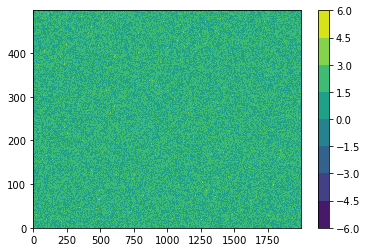

In [10]:
beta = 0.0
#lambda_crit = 1e3
#power_func = lambda kr:1.0/(kr**2 + 1.0/lambda_crit**2)**(beta/2) # Matern-Style
power_func = lambda kr:1.0/kr**(beta)
#power_func = lambda kr:np.ones_like(kr)
#power_func = lambda kr:np.exp(-kr)

Lx = (lon_ax[-1] - lon_ax[0]) * np.cos(centre[0,1]/180.0*np.pi)
Ly = lat_ax[-1] -lat_ax[0]

repetitions = 100

multi_z = generate_from_power_2d_alt(loni.shape[1],loni.shape[0],Lx,Ly,power_func,repetitions=repetitions)
for i in range(repetitions):

    #z,P,C = spectral_tools.generate_from_power_2d(loni.shape[1],loni.shape[0],Lx,Ly,power_func,additional_returns=True)
    multi_z[i] = multi_z[i]/multi_z[i].std()

z = multi_z[0]
plt.contourf(z)
plt.colorbar()

In [11]:

targets = [0.01,0.05,0.1]
target_dists = np.zeros((len(multi_z),len(targets),len(depth_vals)),dtype=int)
for i,z in enumerate(multi_z):
    contrib = results_norm.reshape((7,)+loni.shape) * z[None]
    contrib = contrib.reshape((7,loni.size))
    contrib_sum_norm = np.cumsum(contrib[:,ix].T,axis=0)/np.sum(contrib[:,ix].T,axis=0)
    farfield = 1 - contrib_sum_norm

    for j,target in enumerate(targets):
        # Look for systematic reaching of goal
        # For this, I turn the vector around, to find the *last place* where it overshot the 
        # error, instead of looking for the first place where it undershoots
        target_dist = np.argmax(np.abs(farfield[::-1])>target,axis=0)
        target_dists[i,j] = target_dist

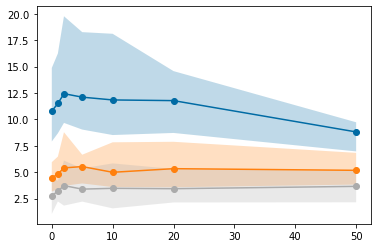

In [12]:
glorkon = 110.0*(dist[ix][::-1][target_dists])
glorkon_rescale=glorkon/(1e-3*np.array(depth_vals)+1e-3*fake_height)
    
for i in range(len(targets)):
    plt.plot(1e-3*np.array(depth_vals),np.median(glorkon_rescale[:,i],axis=0),'-o')
    plt.fill_between(1e-3*np.array(depth_vals),np.percentile(glorkon_rescale[:,i],25,axis=0),np.percentile(glorkon_rescale[:,i],75,axis=0),alpha=0.25)

### Correlated source field with beta

c:\Users\sungw509\Anaconda3\envs\pyshtools\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


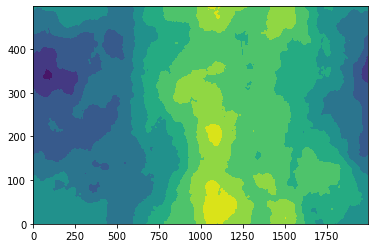

In [13]:
beta = 4.0
#lambda_crit = 1e3
#power_func = lambda kr:1.0/(kr**2 + 1.0/lambda_crit**2)**(beta/2) # Matern-Style
power_func = lambda kr:1.0/kr**(beta)
#power_func = lambda kr:np.ones_like(kr)
#power_func = lambda kr:np.exp(-kr)

Lx = (lon_ax[-1] - lon_ax[0]) * np.cos(centre[0,1]/180.0*np.pi)
Ly = lat_ax[-1] -lat_ax[0]

repetitions = 100

multi_z = generate_from_power_2d_alt(loni.shape[1],loni.shape[0],Lx,Ly,power_func,repetitions=repetitions)
for i in range(repetitions):

    #z,P,C = spectral_tools.generate_from_power_2d(loni.shape[1],loni.shape[0],Lx,Ly,power_func,additional_returns=True)
    multi_z[i] = multi_z[i]/multi_z[i].std()

z = multi_z[0]
plt.contourf(z)

targets = [0.01,0.05,0.1]
target_dists = np.zeros((len(multi_z),len(targets),len(depth_vals)),dtype=int)
for i,z in enumerate(multi_z):
    contrib = results_norm.reshape((7,)+loni.shape) * z[None]
    contrib = contrib.reshape((7,loni.size))
    contrib_sum_norm = np.cumsum(contrib[:,ix].T,axis=0)/np.sum(contrib[:,ix].T,axis=0)
    farfield = 1 - contrib_sum_norm

    for j,target in enumerate(targets):
        # Look for systematic reaching of goal
        # For this, I turn the vector around, to find the *last place* where it overshot the 
        # error, instead of looking for the first place where it undershoots
        target_dist = np.argmax(np.abs(farfield[::-1])>target,axis=0)
        target_dists[i,j] = target_dist


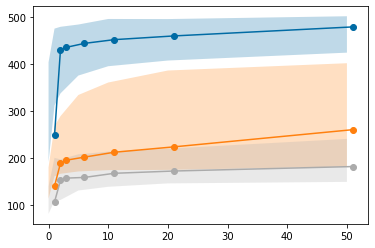

In [14]:
glorkon = 110.0*(dist[ix][::-1][target_dists])
glorkon_rescale=glorkon/(1e-3*np.array(depth_vals)+1e-3*fake_height)
    
for i in range(len(targets)):
    plt.plot(1e-3*np.array(depth_vals)+1e-3*fake_height,np.median(glorkon[:,i],axis=0),'-o')
    plt.fill_between(1e-3*np.array(depth_vals),np.percentile(glorkon[:,i],25,axis=0),np.percentile(glorkon[:,i],75,axis=0),alpha=0.25)

## Spacing

In [6]:
def rms(x):
    return np.sqrt(np.mean(np.square(x)))

def single_block_inversion(worldmap,block_definition,dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,
                                    lambda_d,i,j,iterations=1,far_field = None,
                                    use_extension=False,verbose=False):

    block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
    block_dip = block_definition.assign(*worldmap(dipoles[:,0],dipoles[:,1]))
    
    if far_field is None:
        far_field = np.zeros(aeromag.shape[0])

    equivalent_sources = np.zeros(dipoles.shape[0])
    in_block_dip = (block_dip[0] == i) & (block_dip[1] == j)
    in_block_stat = (block_stat[0] == i) & (block_stat[1] == j)

    if use_extension:
        in_big_block_dip = (np.abs(block_dip[0] - i ) <= 1) & (np.abs(block_dip[1] - j ) <= 1)
        in_big_block_stat = (np.abs(block_stat[0] - i ) <= 1) & (np.abs(block_stat[1] - j ) <= 1)
    else:
        in_big_block_dip = in_block_dip
        in_big_block_stat = in_block_stat

    ano_design_matrix = equi.calculate_ano_design_matrix(aeromag[in_big_block_stat],dipoles[in_big_block_dip],
                                                    igrf_NED_stat[in_big_block_stat],igrf_NED_dip[in_big_block_dip])

    lambda_factor = np.abs(ano_design_matrix.T.dot(ano_design_matrix)).sum(1).mean(0)
    big_matrix = ano_design_matrix.T.dot(ano_design_matrix) + np.eye(ano_design_matrix.shape[1]) * lambda_d * lambda_factor
    temp = np.linalg.solve(big_matrix,ano_design_matrix.T.dot(aeromag[in_big_block_stat,3]-far_field[in_big_block_stat]))
    
    rhs = aeromag[in_big_block_stat,3]-far_field[in_big_block_stat]
    for k in range(iterations):
        temp = temp+np.linalg.solve(big_matrix,ano_design_matrix.T.dot(rhs-ano_design_matrix.dot(temp)))
    temp2 = np.zeros(equivalent_sources.shape)
    temp2[in_big_block_dip] = temp
    equivalent_sources[in_big_block_dip] += temp2[in_big_block_dip]
    return in_big_block_dip,in_big_block_stat,ano_design_matrix,big_matrix,equivalent_sources

def single_block_cv(worldmap,block_definition,dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,
                                    lambda_d,i,j,repetitions,cv_fraction=0.5,iterations=1,far_field = None,
                                    use_extension=False,verbose=False):

    block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
    block_dip = block_definition.assign(*worldmap(dipoles[:,0],dipoles[:,1]))
    
    if far_field is None:
        far_field = np.zeros(aeromag.shape[0])

    equivalent_sources = np.zeros(dipoles.shape[0])
    in_block_dip = (block_dip[0] == i) & (block_dip[1] == j)
    in_block_stat = (block_stat[0] == i) & (block_stat[1] == j)

    if use_extension:
        in_big_block_dip = (np.abs(block_dip[0] - i ) <= 1) & (np.abs(block_dip[1] - j ) <= 1)
        in_big_block_stat = (np.abs(block_stat[0] - i ) <= 1) & (np.abs(block_stat[1] - j ) <= 1)
    else:
        in_big_block_dip = in_block_dip
        in_big_block_stat = in_block_stat

    subbi = aeromag[in_big_block_stat]
    cv_stats = np.zeros((repetitions,2))

    for r in range(repetitions):
        ix = np.random.choice(subbi.shape[0],int(in_big_block_stat.sum()*cv_fraction))
        training = np.zeros(subbi.shape[0],dtype=bool)
        training[ix] = True
        validation = ~training

        ano_design_matrix = equi.calculate_ano_design_matrix(subbi[training],
                                                             dipoles[in_big_block_dip],
                                                        igrf_NED_stat[in_big_block_stat][training],
                                                        igrf_NED_dip[in_big_block_dip])

        lambda_factor = np.abs(ano_design_matrix.T.dot(ano_design_matrix)).sum(1).mean(0)
        big_matrix = ano_design_matrix.T.dot(ano_design_matrix) + np.eye(ano_design_matrix.shape[1]) * lambda_d * lambda_factor
        temp = np.linalg.solve(big_matrix,ano_design_matrix.T.dot(subbi[training,3]-far_field[in_big_block_stat][training]))
        
        rhs = subbi[training,3]-far_field[in_big_block_stat][training]
        for k in range(iterations):
            temp = temp+np.linalg.solve(big_matrix,ano_design_matrix.T.dot(rhs-ano_design_matrix.dot(temp)))
        temp2 = np.zeros(equivalent_sources.shape)
        temp2[in_big_block_dip] = temp
        pred = ano_design_matrix.dot(temp)
        
        cv_stats[r,0] = rms(pred-rhs)
        ano_design_matrix = equi.calculate_ano_design_matrix(subbi[validation],
                                                             dipoles[in_big_block_dip],
                                                        igrf_NED_stat[in_big_block_stat][validation],
                                                        igrf_NED_dip[in_big_block_dip])
        pred_validation = ano_design_matrix.dot(temp)
        rhs = subbi[validation,3]-far_field[in_big_block_stat][validation]
        cv_stats[r,1] = rms(pred_validation-rhs)

    return cv_stats

(1, 2)


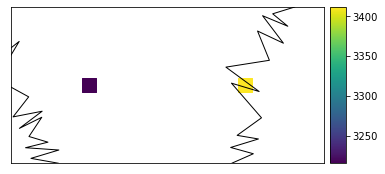

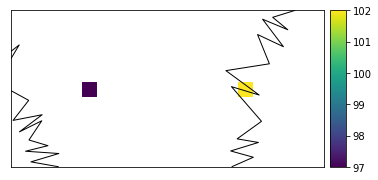

In [40]:
dipole_depth = 0
dipole_spacing = 25e3
aux_spacing = 5000
aux_height = 0

xdp = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+dipole_spacing,dipole_spacing)
ydp = np.arange(worldmap.llcrnry,worldmap.urcrnry+dipole_spacing,dipole_spacing)

xi,yi = np.meshgrid(xdp,ydp)
lonp,latp = worldmap(xi,yi,inverse=True)

dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

xa = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+aux_spacing,aux_spacing)
ya = np.arange(worldmap.llcrnry,worldmap.urcrnry+aux_spacing,aux_spacing)

xi,yi = np.meshgrid(xa,ya)
lona,lata = worldmap(xi,yi,inverse=True)

auxiliary = np.vstack((lona.flatten(),lata.flatten(),aux_height*np.ones(lona.size))).T

igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
order = [1,2,0]
# Note: pyshtools uses rad,theta,phi
# Here I change to NED system
igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
igrf_NED_dip = igrf_NED_dip[:,order]

igrf_NED_aux = igrf_coeffs.expand(lon=lona.flatten(),lat=lata.flatten(),a=6371.2+aux_height*0.001)
igrf_NED_aux[:,0] = - igrf_NED_aux[:,0]
igrf_NED_aux[:,1] = - igrf_NED_aux[:,1]
igrf_NED_aux = igrf_NED_aux[:,order]

igrf_NED_stat = np.squeeze(equi.igrf_comp(aeromag[:,5],aeromag[:,6],aeromag[:,4]))

## Block stuff

block_size = 250e3

block_definition = equi_cart.CartesianBlockDefinition(corners,block_size)
print(block_definition.block_centers()[0].shape)


block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
block_dip = block_definition.assign(*np.meshgrid(xdp,ydp))
station_count = block_definition.count(*worldmap(aeromag[:,0],aeromag[:,1]))
av_station_spacing = np.sqrt(block_size**2/station_count)
dipole_count = block_definition.count(*worldmap(dipoles[:,0],dipoles[:,1]))
xi,yi = block_definition.block_centers()
worldmap.scatter(xi.flat,yi.flat,200,av_station_spacing.flat,'s')
worldmap.colorbar()
worldmap.drawcoastlines()

plt.figure()
worldmap.scatter(xi.flat,yi.flat,200,dipole_count.flat,'s')
worldmap.colorbar()
worldmap.drawcoastlines()

In [43]:
block_sel = 0,0

igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
order = [1,2,0]

dipole_depths = np.arange(-1000,50e3,5000)
lambda_ds = np.logspace(-3,1,5)
cv_repetitions = 16
results = np.zeros((len(dipole_depths),len(lambda_ds)))
cond_numbers = np.zeros((len(dipole_depths),len(lambda_ds)))
cv_stats = np.zeros((len(dipole_depths),len(lambda_ds),cv_repetitions,2))

timer = utils.ETA(results.size,wait_time=5)

for i,dipole_depth in enumerate(dipole_depths):
    dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

    # Note: pyshtools uses rad,theta,phi
    # Here I change to NED system
    igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
    igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
    igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
    igrf_NED_dip = igrf_NED_dip[:,order]
    for j,lambda_d in enumerate(lambda_ds):
        in_big_block_dip,in_big_block_stat,ano_design_matrix,big_matrix,test = single_block_inversion(worldmap,block_definition,dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,lambda_d,block_sel[0],block_sel[1],use_extension=False)
        pred = ano_design_matrix.dot(test[in_big_block_dip])
        #print(np.linalg.cond(big_matrix),rms(pred-aeromag[in_big_block_stat,3]))
        results[i,j] = (rms(pred-aeromag[in_big_block_stat,3]))
        cond_numbers[i,j] = np.linalg.cond(big_matrix)
        cv_stats[i,j] = single_block_cv(worldmap,block_definition,dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,lambda_d,block_sel[0],block_sel[1],cv_repetitions)
        timer()

5.5 % complete ETA 97.82 s
10.9 % complete ETA 91.45 s
16.4 % complete ETA 86.07 s
21.8 % complete ETA 81.52 s
27.3 % complete ETA 75.94 s
32.7 % complete ETA 70.38 s
38.2 % complete ETA 64.76 s
43.6 % complete ETA 59.23 s
49.1 % complete ETA 53.61 s
54.5 % complete ETA 47.95 s
60.0 % complete ETA 42.29 s
65.5 % complete ETA 36.62 s
70.9 % complete ETA 30.91 s
76.4 % complete ETA 25.14 s
81.8 % complete ETA 19.36 s
87.3 % complete ETA 13.58 s
92.7 % complete ETA 7.77 s
98.2 % complete ETA 1.94 s


(0.0, 200.0)

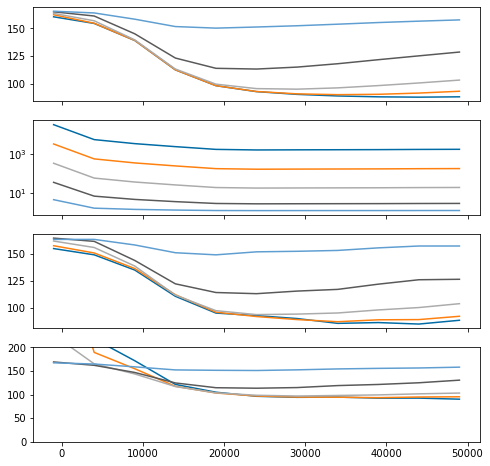

In [51]:
fig,axs = plt.subplots(4,1,sharex=True,figsize=(8,8))

axs[0].plot(dipole_depths,results)
axs[1].semilogy(dipole_depths,cond_numbers)
axs[2].plot(dipole_depths,cv_stats[:,:,:,0].mean(2))
axs[3].plot(dipole_depths,cv_stats[:,:,:,1].mean(2))
axs[3].set_ylim([0,200])

## Gauss-Seidel/Jacobi approach

In [188]:
def single_block_inner(dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,
                                    lambda_d,iterations=1,far_field = None,year_shift=None):

    if far_field is None:
        far_field = np.zeros(aeromag.shape[0])
    if year_shift is None:
        year_shift = np.zeros(aeromag.shape[0])

    ano_design_matrix = equi.calculate_ano_design_matrix(aeromag,dipoles,
                                                    igrf_NED_stat,igrf_NED_dip)

    lambda_factor = np.abs(ano_design_matrix.T.dot(ano_design_matrix)).sum(1).mean(0)
    big_matrix = ano_design_matrix.T.dot(ano_design_matrix) + np.eye(ano_design_matrix.shape[1]) * lambda_d * lambda_factor
    rhs = aeromag[:,3]-far_field-year_shift
    
    temp = np.linalg.solve(big_matrix,ano_design_matrix.T.dot(rhs))
    
    for k in range(iterations):
        temp = temp+np.linalg.solve(big_matrix,ano_design_matrix.T.dot(rhs-ano_design_matrix.dot(temp)))
    return ano_design_matrix,temp

(5, 10)


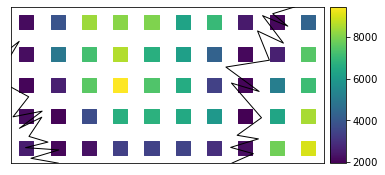

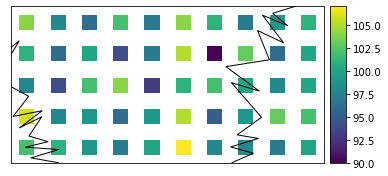

In [210]:
dipole_depth = 5e3
dipole_spacing = 5e3
aux_spacing = 5000
aux_height = 0

xdp = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+dipole_spacing,dipole_spacing)
ydp = np.arange(worldmap.llcrnry,worldmap.urcrnry+dipole_spacing,dipole_spacing)

xi,yi = np.meshgrid(xdp,ydp)
lonp,latp = worldmap(xi,yi,inverse=True)

dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

xa = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+aux_spacing,aux_spacing)
ya = np.arange(worldmap.llcrnry,worldmap.urcrnry+aux_spacing,aux_spacing)

xi,yi = np.meshgrid(xa,ya)
lona,lata = worldmap(xi,yi,inverse=True)

auxiliary = np.vstack((lona.flatten(),lata.flatten(),aux_height*np.ones(lona.size))).T

igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
order = [1,2,0]
# Note: pyshtools uses rad,theta,phi
# Here I change to NED system
igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
igrf_NED_dip = igrf_NED_dip[:,order]

igrf_NED_aux = igrf_coeffs.expand(lon=lona.flatten(),lat=lata.flatten(),a=6371.2+aux_height*0.001)
igrf_NED_aux[:,0] = - igrf_NED_aux[:,0]
igrf_NED_aux[:,1] = - igrf_NED_aux[:,1]
igrf_NED_aux = igrf_NED_aux[:,order]

igrf_NED_stat = np.squeeze(equi.igrf_comp(aeromag[:,5],aeromag[:,6],aeromag[:,4]))

## Block stuff

block_size = 50e3

block_definition = equi_cart.CartesianBlockDefinition(corners,block_size)
print(block_definition.block_centers()[0].shape)


block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
block_dip = block_definition.assign(*np.meshgrid(xdp,ydp))
station_count = block_definition.count(*worldmap(aeromag[:,0],aeromag[:,1]))
av_station_spacing = np.sqrt(block_size**2/station_count)
dipole_count = block_definition.count(*worldmap(dipoles[:,0],dipoles[:,1]))
xi,yi = block_definition.block_centers()
worldmap.scatter(xi.flat,yi.flat,200,av_station_spacing.flat,'s')
worldmap.colorbar()
worldmap.drawcoastlines()

plt.figure()
worldmap.scatter(xi.flat,yi.flat,200,dipole_count.flat,'s')
worldmap.colorbar()
worldmap.drawcoastlines()

In [234]:
block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
block_dip = block_definition.assign(*worldmap(dipoles[:,0],dipoles[:,1]))


rounds = 5
lambda_d = 0.1

equivalent_sources = np.zeros((rounds,dipoles.shape[0]))
far_field = np.zeros((rounds+1,aeromag.shape[0]))
year_shift = np.zeros((rounds+1,aeromag.shape[0]))
predicted = np.zeros((rounds,aeromag.shape[0]))

for k in range(rounds):
    for i,j in block_definition:
        in_block_dip = (block_dip[0] == i) & (block_dip[1] == j)
        in_block_stat = (block_stat[0] == i) & (block_stat[1] == j)
        if in_block_dip.sum() == 0 or in_block_stat.sum() == 0:
            continue
        
        ano_design_matrix,temp = single_block_inner(dipoles[in_block_dip],aeromag[in_block_stat],
                                                    igrf_NED_dip[in_block_dip],igrf_NED_stat[in_block_stat],
                                                    lambda_d,iterations = 0,far_field = far_field[k][in_block_stat])
        equivalent_sources[k,in_block_dip] += temp
        predicted[k,in_block_stat] = ano_design_matrix.dot(temp)
    far_field[k+1] = equi_cart.calculate_far_field(worldmap,block_definition,dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,equivalent_sources[k])
    # Calculate yearly shift
    misfit = predicted[k] + far_field[k] - aeromag[:,3]
    yearly_mean = np.zeros(len(np.unique(years)))
    for i,y in enumerate(np.unique(years)):
        yearly_mean[i]= misfit[years==y].mean()
        year_shift[k+1,years==y] = yearly_mean[i]
        

In [235]:
for k in range(rounds):
    print(rms(predicted[k]+far_field[k]-year_shift[k]-aeromag[:,3]),rms(predicted[k]+far_field[k+1]-year_shift[k]-aeromag[:,3]))

110.97484597545699 125.89883444958842
104.20186895913915 106.79892792417314
104.4961778175232 104.47886782816866
104.43168269315568 104.54557680794244
104.47927025074893 104.45498981084349


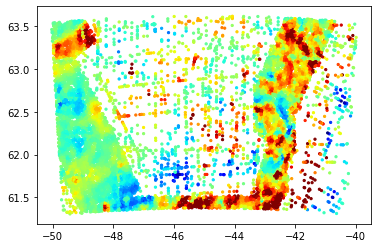

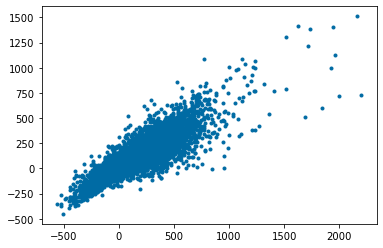

In [236]:
plt.scatter(aeromag[:,0],aeromag[:,1],5,predicted[0],vmin=-400,vmax=400,cmap=plt.cm.jet)
plt.figure()
plt.plot(aeromag[:,3],predicted[0],'.')

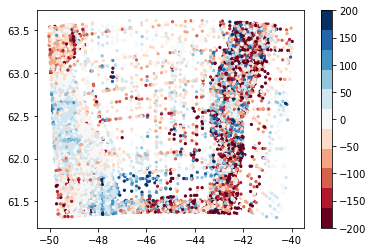

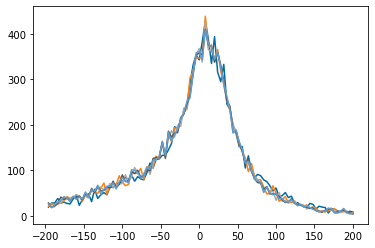

In [237]:
plt.scatter(aeromag[:,0],aeromag[:,1],5,predicted[0]+far_field[0]-aeromag[:,3],vmin=-200,vmax=200,cmap=plt.cm.get_cmap("RdBu",11))
plt.colorbar()
plt.figure()
for k in range(rounds):
    histo = np.histogram(predicted[k]+far_field[k]-aeromag[:,3],bins=np.linspace(-200,200,101))
    plt.plot(histo[1][1:],histo[0])

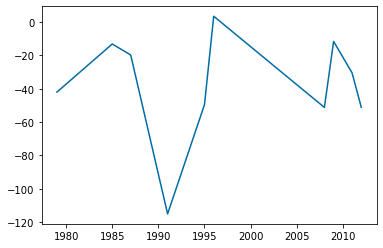

In [240]:
misfit = predicted[-1] + far_field[-1] - 0*year_shift[-2] - aeromag[:,3]
yearly_mean = np.zeros(len(np.unique(years)))
for i,y in enumerate(np.unique(years)):
    yearly_mean[i]= misfit[years==y].mean()
plt.plot(np.unique(years),yearly_mean)

c:\Users\sungw509\Anaconda3\envs\pyshtools\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(-0.5, 0.5)

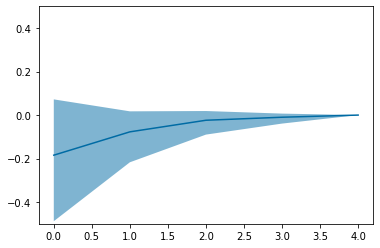

In [233]:
glorkon = (equivalent_sources-equivalent_sources[-1])/equivalent_sources[-1]
plt.plot(np.arange(rounds),np.nanmedian(glorkon,1))
plt.fill_between(np.arange(rounds),np.nanpercentile(glorkon,25,axis=1),np.nanpercentile(glorkon,75,axis=1),alpha=0.5)
plt.ylim([-0.5,0.5])

In [427]:
def eq_run_jacobi(dipole_spacing,aeromag,rounds = 5, use_yearshift=True,aux_spacing=5000,height_factor=1):
    dipole_depth = dipole_spacing * height_factor
    block_size = 10 * dipole_spacing

    xdp = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+dipole_spacing,dipole_spacing)
    ydp = np.arange(worldmap.llcrnry,worldmap.urcrnry+dipole_spacing,dipole_spacing)

    xi,yi = np.meshgrid(xdp,ydp)
    lonp,latp = worldmap(xi,yi,inverse=True)

    dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

    igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
    order = [1,2,0]
    # Note: pyshtools uses rad,theta,phi
    # Here I change to NED system
    igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
    igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
    igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
    igrf_NED_dip = igrf_NED_dip[:,order]
    igrf_NED_stat = np.squeeze(equi.igrf_comp(aeromag[:,5],aeromag[:,6],aeromag[:,4]))

    ## Block stuff

    block_definition = equi_cart.CartesianBlockDefinition(corners,block_size)

    block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
    block_dip = block_definition.assign(*np.meshgrid(xdp,ydp))
    block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
    block_dip = block_definition.assign(*worldmap(dipoles[:,0],dipoles[:,1]))

    equivalent_sources = np.zeros((rounds,dipoles.shape[0]))
    far_field = np.zeros((rounds+1,aeromag.shape[0]))
    year_shift = np.zeros((rounds+1,aeromag.shape[0]))
    predicted = np.zeros((rounds,aeromag.shape[0]))

    for k in range(rounds):
        for i,j in block_definition:
            in_block_dip = (block_dip[0] == i) & (block_dip[1] == j)
            in_block_stat = (block_stat[0] == i) & (block_stat[1] == j)
            if in_block_dip.sum() == 0 or in_block_stat.sum() == 0:
                continue
            
            ano_design_matrix,temp = single_block_inner(dipoles[in_block_dip],aeromag[in_block_stat],
                                                        igrf_NED_dip[in_block_dip],igrf_NED_stat[in_block_stat],
                                                        lambda_d,iterations = 0,far_field = far_field[k][in_block_stat],
                                                        year_shift=year_shift[k][in_block_stat])
            equivalent_sources[k,in_block_dip] += temp
            predicted[k,in_block_stat] = ano_design_matrix.dot(temp)
        far_field[k+1] = equi_cart.calculate_far_field(worldmap,block_definition,dipoles,aeromag,igrf_NED_dip,igrf_NED_stat,equivalent_sources[k])
        # Calculate yearly shift
        misfit = predicted[k] + far_field[k] - aeromag[:,3]
        if use_yearshift:
            yearly_mean = np.zeros(len(np.unique(years)))
            for i,y in enumerate(np.unique(years)):
                yearly_mean[i] = misfit[years==y].mean()
                year_shift[k+1,years==y] = yearly_mean[i]
        print(rms(predicted[k]+far_field[k]-year_shift[k]-aeromag[:,3]),rms(predicted[k]+far_field[k+1]-year_shift[k]-aeromag[:,3]))
    
    ## Auxilliary prediction
    xa = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+aux_spacing,aux_spacing)
    ya = np.arange(worldmap.llcrnry,worldmap.urcrnry+aux_spacing,aux_spacing)

    xi,yi = np.meshgrid(xa,ya)
    lona,lata = worldmap(xi,yi,inverse=True)

    auxiliary = np.vstack((lona.flatten(),lata.flatten(),aux_height*np.ones(lona.size))).T

    igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
    order = [1,2,0]
    # Note: pyshtools uses rad,theta,phi
    # Here I change to NED system
    igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
    igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
    igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
    igrf_NED_dip = igrf_NED_dip[:,order]

    igrf_NED_aux = igrf_coeffs.expand(lon=lona.flatten(),lat=lata.flatten(),a=6371.2+aux_height*0.001)
    igrf_NED_aux[:,0] = - igrf_NED_aux[:,0]
    igrf_NED_aux[:,1] = - igrf_NED_aux[:,1]
    igrf_NED_aux = igrf_NED_aux[:,order]

    aux_field = equi_cart.calculate_far_field(worldmap,block_definition,dipoles,auxiliary,
                                              igrf_NED_dip,igrf_NED_aux,equivalent_sources[-1],
                                              inner=0,outer=1)
    auxiliary = np.hstack((auxiliary,aux_field[:,None]))
    return dipoles,equivalent_sources,predicted,far_field,year_shift,auxiliary.reshape((lona.shape+(4,)))

In [428]:
dipoles,equivalent_sources,predicted,far_field,year_shift,auxililary = eq_run_jacobi(25e3,aeromag,rounds=5,aux_spacing=1000,height_factor=2)

158.5647955204861 159.97681696272792
155.72775463385173 155.46501071096
155.45487745809322 155.3482989934786
155.3980040721842 155.34274758647902
155.19488803683225 155.22597626942144


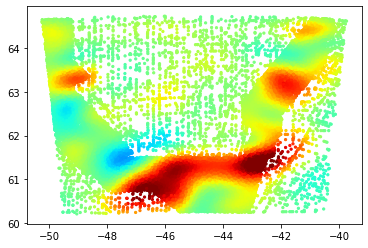

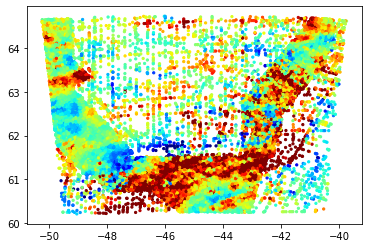

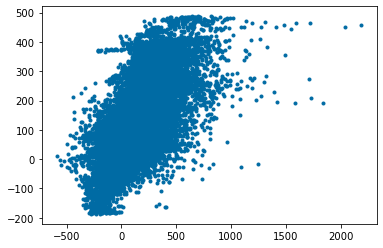

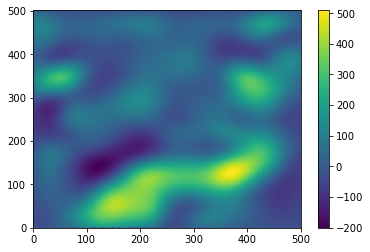

In [429]:
plt.scatter(aeromag[:,0],aeromag[:,1],5,predicted[-1]+far_field[-1],vmin=-400,vmax=400,cmap=plt.cm.jet)
plt.figure()
plt.scatter(aeromag[:,0],aeromag[:,1],5,aeromag[:,3],vmin=-400,vmax=400,cmap=plt.cm.jet)
plt.figure()
plt.plot(aeromag[:,3],predicted[0],'.')
plt.figure()
plt.pcolormesh(auxililary[...,3])
plt.colorbar()

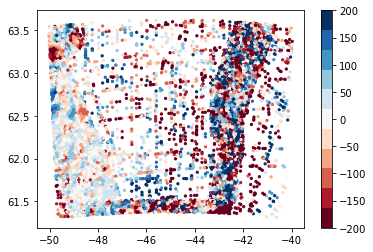

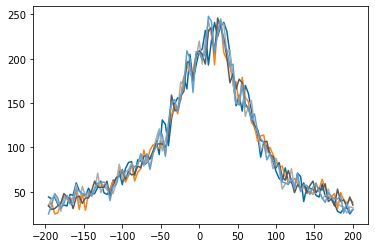

In [297]:
plt.scatter(aeromag[:,0],aeromag[:,1],5,predicted[-1]+far_field[-1]-aeromag[:,3],vmin=-200,vmax=200,cmap=plt.cm.get_cmap("RdBu",11))
plt.colorbar()
plt.figure()
for k in range(rounds):
    histo = np.histogram(predicted[k]+far_field[k]-aeromag[:,3],bins=np.linspace(-200,200,101))
    plt.plot(histo[1][1:],histo[0])

In [298]:
misfit = predicted[-1] + far_field[-1] - aeromag[:,3]
yearly_mean = np.zeros(len(np.unique(years)))
for i,y in enumerate(np.unique(years)):
    yearly_mean[i] = misfit[years==y].mean()

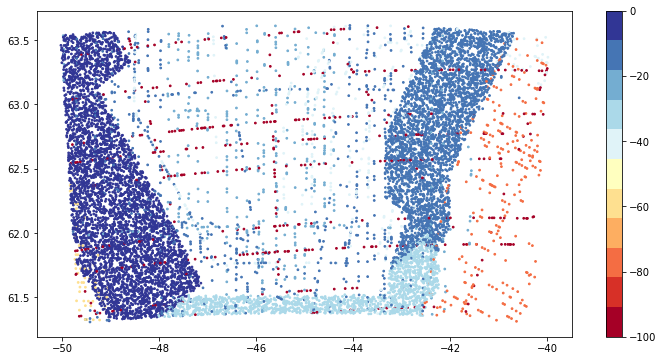

In [299]:
plt.figure(figsize=(12,6))
plt.scatter(aeromag[:,0],aeromag[:,1],3,year_shift[-1],vmin=-100,vmax=0,cmap=plt.cm.get_cmap("RdYlBu",11))
plt.colorbar()

## Multi-run GS/Jacobi approach

In [430]:
results_25 = eq_run_jacobi(25e3,aeromag,use_yearshift=False,rounds=3,height_factor=2)
dipoles,equivalent_sources,predicted,far_field,year_shift,auxiliary = results_25
aeromag_reduced_25 = aeromag.copy()
aeromag_reduced_25[:,3] = aeromag_reduced_25[:,3] - (predicted[-1] - far_field[-1] + year_shift[-1])

results_5 = eq_run_jacobi(5e3,aeromag_reduced_25,use_yearshift=False,rounds=3,height_factor=2)
dipoles,equivalent_sources,predicted,far_field,year_shift,auxiliary = results_5

aeromag_reduced_5 = aeromag_reduced_25.copy()
aeromag_reduced_5[:,3] = aeromag_reduced_5[:,3] - (predicted[-1] - far_field[-1] + year_shift[-1])

results_1 = eq_run_jacobi(1e3,aeromag_reduced_5,use_yearshift=False,rounds=3,height_factor=2)
dipoles,equivalent_sources,predicted,far_field,year_shift,auxiliary = results_1


158.5647955204861 159.97681696272792
157.83123590826543 158.69940167547333
157.92759323959714 157.8399894787092
103.47953440072015 104.08071522214847
100.68692400350295 103.82494236946033
101.70098468901246 101.3801426597529
46.84813634573106 53.987516269535014
44.00651699234796 50.94007416914178
45.5079922488992 45.86533031296946


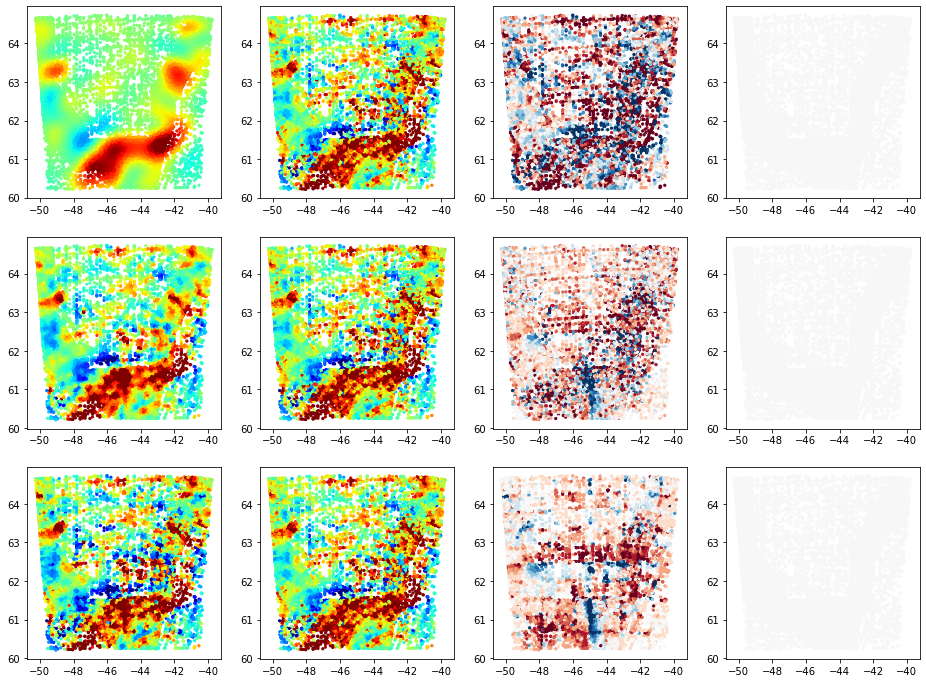

In [431]:
fig,axs = plt.subplots(3,4,figsize=(16,12))

predicted = np.zeros((3,aeromag.shape[0]))
far_field = np.zeros((4,aeromag.shape[0]))
year_shift = np.zeros((4,aeromag.shape[0]))
auxiliary[...,3] = 0

for k,results in enumerate([results_25,results_5,results_1]):
    predicted += results[2]
    far_field += results[3] 
    year_shift+= results[4] 
    auxiliary[...,3] += results[5][...,3]

    axs[k,0].scatter(aeromag[:,0],aeromag[:,1],5,predicted[-1]+far_field[-1],vmin=-400,vmax=400,cmap=plt.cm.jet)
    axs[k,1].scatter(aeromag[:,0],aeromag[:,1],5,aeromag[:,3]-year_shift[-1],vmin=-400,vmax=400,cmap=plt.cm.jet)
    axs[k,2].scatter(aeromag[:,0],aeromag[:,1],5,predicted[-1]+far_field[-1]+year_shift[-1]-aeromag[:,3],vmin=-200,vmax=200,cmap=plt.cm.get_cmap("RdBu",11))
    axs[k,3].scatter(aeromag[:,0],aeromag[:,1],5,year_shift[-1],vmin=-200,vmax=200,cmap=plt.cm.get_cmap("RdBu",11))

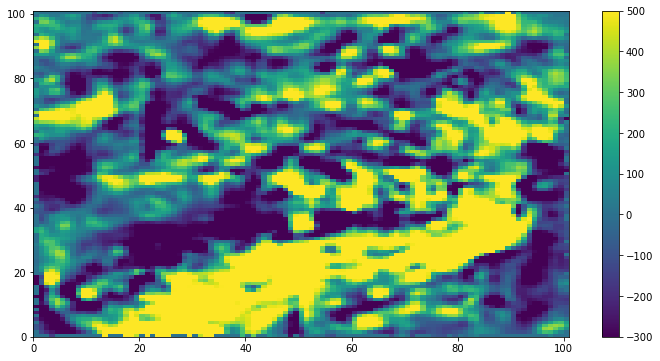

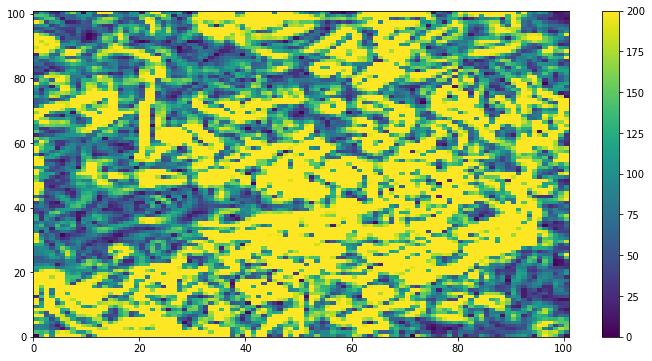

In [439]:
plt.figure(figsize=(12,6))
plt.pcolormesh(auxiliary[...,3],vmin=-300,vmax=500)
plt.colorbar()

plt.figure(figsize=(12,6))
thg = np.sqrt(np.gradient(auxiliary[...,3],axis=1)**2 + np.gradient(auxiliary[...,3],axis=0)**2)
plt.pcolormesh(thg,vmax=200)
plt.colorbar()

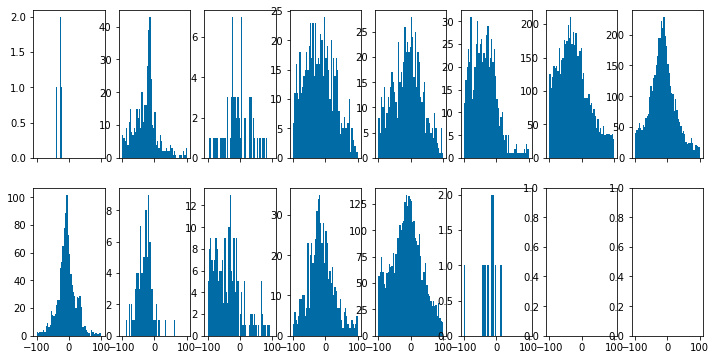

In [440]:
misfit = predicted[-1] + far_field[-1] - aeromag[:,3]
yearly_mean = np.zeros(len(np.unique(years)))
year_shift = np.zeros(aeromag.shape[0])
fig,axs = plt.subplots(2,8,figsize=(12,6),sharex=True)
axs = axs.flatten()
for i,y in enumerate(np.unique(years)):
    yearly_mean[i] = misfit[years==y].mean()
    year_shift[years==y] = yearly_mean[i]
    axs[i].hist(misfit[years==y],np.linspace(-100,100,51))

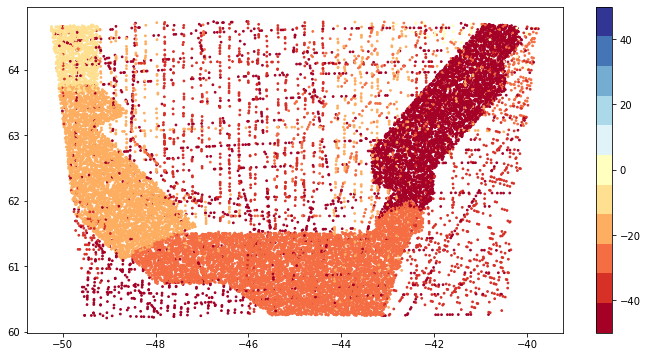

In [441]:
plt.figure(figsize=(12,6))
plt.scatter(aeromag[:,0],aeromag[:,1],3,year_shift,vmin=-50,vmax=50,cmap=plt.cm.get_cmap("RdYlBu",11))
plt.colorbar()

## Extension method

In [715]:
def eq_run_extend(dipole_spacing,aeromag, year_shift=None,aux_spacing=5000,
                  height_factor=1,block_factor=3.3,lambda_d=0.1,igrf_year=2014.0,fill_threshold=0.0):
    dipole_depth = dipole_spacing * height_factor
    block_size = dipole_spacing * block_factor

    if year_shift is None:
        year_shift = np.zeros(aeromag.shape[0])

    xdp = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+dipole_spacing,dipole_spacing)
    ydp = np.arange(worldmap.llcrnry,worldmap.urcrnry+dipole_spacing,dipole_spacing)

    xi,yi = np.meshgrid(xdp,ydp)
    lonp,latp = worldmap(xi,yi,inverse=True)

    dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

    igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=igrf_year),6371.2)
    order = [1,2,0]
    # Note: pyshtools uses rad,theta,phi
    # Here I change to NED system
    igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
    igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
    igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
    igrf_NED_dip = igrf_NED_dip[:,order]
    igrf_NED_stat = np.squeeze(equi.igrf_comp(aeromag[:,5],aeromag[:,6],aeromag[:,4]))

    ## Block stuff

    block_definition = equi_cart.CartesianBlockDefinition(corners,block_size)

    block_stat = block_definition.assign(*worldmap(aeromag[:,0],aeromag[:,1]))
    block_dip = block_definition.assign(*worldmap(dipoles[:,0],dipoles[:,1]))

    equivalent_sources = np.zeros((dipoles.shape[0]))
    predicted = np.zeros((aeromag.shape[0]))
    for i,j in block_definition:
        in_block_dip = (block_dip[0] == i) & (block_dip[1] == j)
        in_block_stat = (block_stat[0] == i) & (block_stat[1] == j)
        
        fill_ratio = in_block_stat.sum() / in_block_dip.sum()
        if in_block_dip.sum() == 0 or in_block_stat.sum() == 0:
            continue
        elif fill_ratio < fill_threshold:
            continue
        
        in_big_block_dip = (np.abs(block_dip[0] - i ) <= 1) & (np.abs(block_dip[1] - j ) <= 1)
        in_big_block_stat = (np.abs(block_stat[0] - i ) <= 1) & (np.abs(block_stat[1] - j ) <= 1)

        ano_design_matrix,temp = single_block_inner(dipoles[in_big_block_dip],aeromag[in_big_block_stat],
                                                    igrf_NED_dip[in_big_block_dip],igrf_NED_stat[in_big_block_stat],
                                                    lambda_d,iterations = 0,year_shift=year_shift[in_big_block_stat])
        tomp = np.zeros(dipoles.shape[0])
        tomp[in_big_block_dip] += temp
        equivalent_sources[in_block_dip] += tomp[in_block_dip]
        tank = np.zeros(aeromag.shape[0])
        tank[in_big_block_stat] = ano_design_matrix.dot(temp)
        predicted[in_block_stat] = tank[in_block_stat]
    print(rms(predicted-year_shift-aeromag[:,3]))

    ## Auxilliary prediction
    xa = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+aux_spacing,aux_spacing)
    ya = np.arange(worldmap.llcrnry,worldmap.urcrnry+aux_spacing,aux_spacing)

    xi,yi = np.meshgrid(xa,ya)
    lona,lata = worldmap(xi,yi,inverse=True)

    auxiliary = np.vstack((lona.flatten(),lata.flatten(),aux_height*np.ones(lona.size))).T

    igrf_coeffs = pysh.SHMagCoeffs.from_array(pysh.shio.read_igrf('igrf13coeffs.txt',year=2014.0),6371.2)
    order = [1,2,0]
    # Note: pyshtools uses rad,theta,phi
    # Here I change to NED system
    igrf_NED_dip = igrf_coeffs.expand(lon=lonp.flatten(),lat=latp.flatten(),a=6371.2-0.001*dipole_depth)
    igrf_NED_dip[:,0] = - igrf_NED_dip[:,0]
    igrf_NED_dip[:,1] = - igrf_NED_dip[:,1]
    igrf_NED_dip = igrf_NED_dip[:,order]

    igrf_NED_aux = igrf_coeffs.expand(lon=lona.flatten(),lat=lata.flatten(),a=6371.2+aux_height*0.001)
    igrf_NED_aux[:,0] = - igrf_NED_aux[:,0]
    igrf_NED_aux[:,1] = - igrf_NED_aux[:,1]
    igrf_NED_aux = igrf_NED_aux[:,order]

    aux_field = equi_cart.calculate_far_field(worldmap,block_definition,dipoles,auxiliary,
                                              igrf_NED_dip,igrf_NED_aux,equivalent_sources,
                                              inner=0,outer=1)
    auxiliary = np.hstack((auxiliary,aux_field[:,None]))
    return dipoles,equivalent_sources,predicted,year_shift,auxiliary.reshape((lona.shape+(4,)))


def block_analysis(aeromag,dipole_spacing,block_factor):
    block_size = dipole_spacing * block_factor
    xdp = np.arange(worldmap.llcrnrx,worldmap.urcrnrx+dipole_spacing,dipole_spacing)
    ydp = np.arange(worldmap.llcrnry,worldmap.urcrnry+dipole_spacing,dipole_spacing)

    xi,yi = np.meshgrid(xdp,ydp)
    lonp,latp = worldmap(xi,yi,inverse=True)

    dipoles = np.vstack((lonp.flatten(),latp.flatten(),-dipole_depth*np.ones(lonp.size))).T

    block_definition = equi_cart.CartesianBlockDefinition(corners,block_size)

    station_count = block_definition.count(*worldmap(aeromag[:,0],aeromag[:,1]))
    dipole_count = block_definition.count(*worldmap(dipoles[:,0],dipoles[:,1]))

    return block_definition,station_count,dipole_count

    

In [727]:
multi_res_results = []
spacings = np.array([32e3,16e3,8e3,4e3,2e3])
fill_threshold = 1.0
aeromag_reduced = aeromag.copy()
yearly_means = np.zeros((len(spacings),2,len(np.unique(years))))

for k,spacing in enumerate(spacings):
    prelim = eq_run_extend(spacing,aeromag_reduced,aux_spacing=5000,height_factor=4,
                                           block_factor=15,lambda_d=0.5,fill_threshold=fill_threshold)
    ## Apply yearly shift
    misfit = aeromag_reduced[:,3] - prelim[2]
    year_shift = np.zeros(aeromag.shape[0])
    for i,y in enumerate(np.unique(years)):
        yearly_means[k,0,i] = misfit[years==y].mean()
        year_shift[years==y] = yearly_means[k,0,i]
    
    aeromag_reduced[:,3] = aeromag_reduced[:,3] - year_shift
    multi_res_results.append(eq_run_extend(spacing,aeromag_reduced,aux_spacing=5000,height_factor=2,
                                           block_factor=15,lambda_d=0.5,fill_threshold=fill_threshold))
    aeromag_reduced[:,3] = aeromag_reduced[:,3] - multi_res_results[-1][2]

    misfit = aeromag_reduced[:,3] - multi_res_results[-1][2]
    for i,y in enumerate(np.unique(years)):
        yearly_means[k,1,i] = misfit[years==y].mean()

predicted = np.cumsum([m[2] for m in multi_res_results],axis=0)
auxiliary = np.cumsum([m[4] for m in multi_res_results],axis=0)

# Calculate shift corrected data
aeromag_shifted = aeromag.copy()
for k in range(len(spacings)):
    for i,y in enumerate(np.unique(years)):
        aeromag_shifted[years==y,3] = aeromag_shifted[years==y,3] - yearly_means[k,0,i]

132.11476362782597
106.59125699410497
102.24455053107229
94.14003755300173
88.5801093556273
78.92515330099711
72.35375854678219
63.4398122561706
62.98162179565825
62.488010129916475


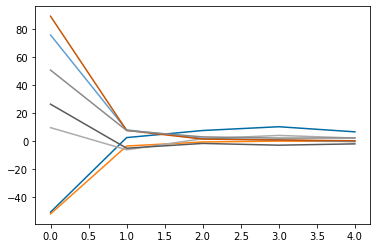

In [728]:
plt.plot(np.arange(len(spacings)),yearly_means[:,0,:])

-0.07184461711193534
-0.009262536413485681
-0.0033398742735224864
0.007368607128723627


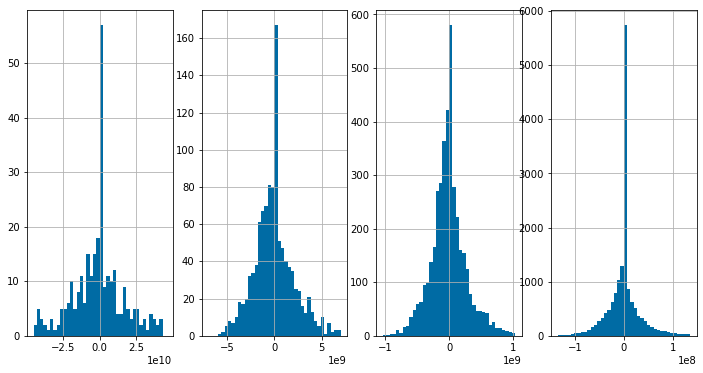

In [729]:
fig,axs = plt.subplots(1,4,figsize=(12,6))
for m,ax in zip(multi_res_results,axs):
    klonk = np.percentile(np.abs(m[1]),99)
    left,right  = -klonk,klonk
    ax.hist(m[1].flatten(),np.linspace(left,right,41))
    ax.grid()
    print(m[1].mean()/m[1].std())

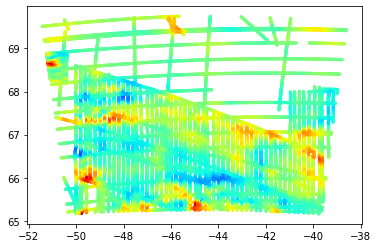

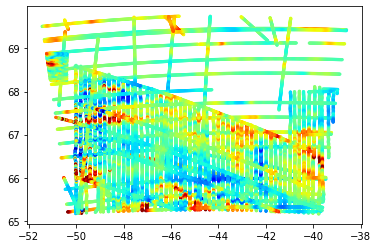

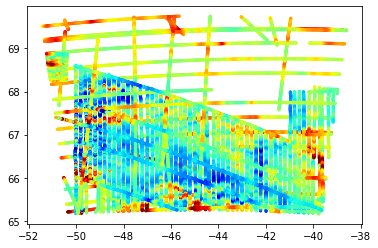

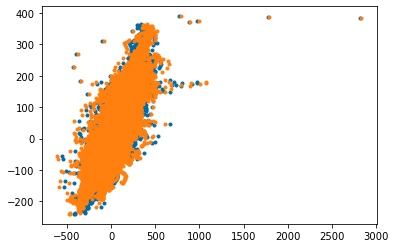

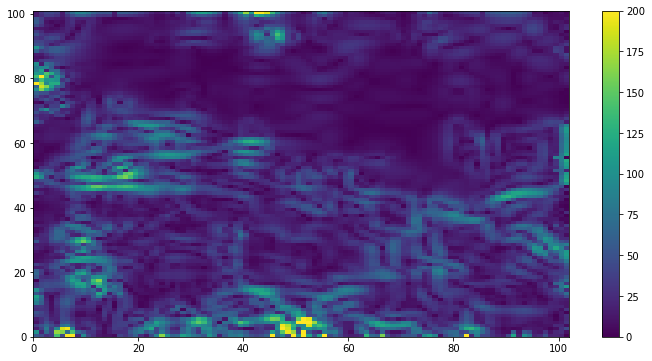

In [730]:
plt.scatter(aeromag[:,0],aeromag[:,1],5,predicted[-1],vmin=-400,vmax=400,cmap=plt.cm.jet)
plt.figure()
plt.scatter(aeromag[:,0],aeromag[:,1],5,aeromag_shifted[:,3],vmin=-400,vmax=400,cmap=plt.cm.jet)
plt.figure()
plt.scatter(aeromag[:,0],aeromag[:,1],5,aeromag[:,3],vmin=-400,vmax=400,cmap=plt.cm.jet)
plt.figure()
plt.plot(aeromag_shifted[:,3],predicted[-1],'.')
plt.plot(aeromag[:,3],predicted[-1],'.')

plt.figure(figsize=(12,6))
thg = np.maximum(np.abs((np.gradient(auxiliary[-1,...,3],axis=0))), np.abs(np.gradient(auxiliary[-1,...,3],axis=1)))
plt.pcolormesh(thg,vmax=200)
plt.colorbar()

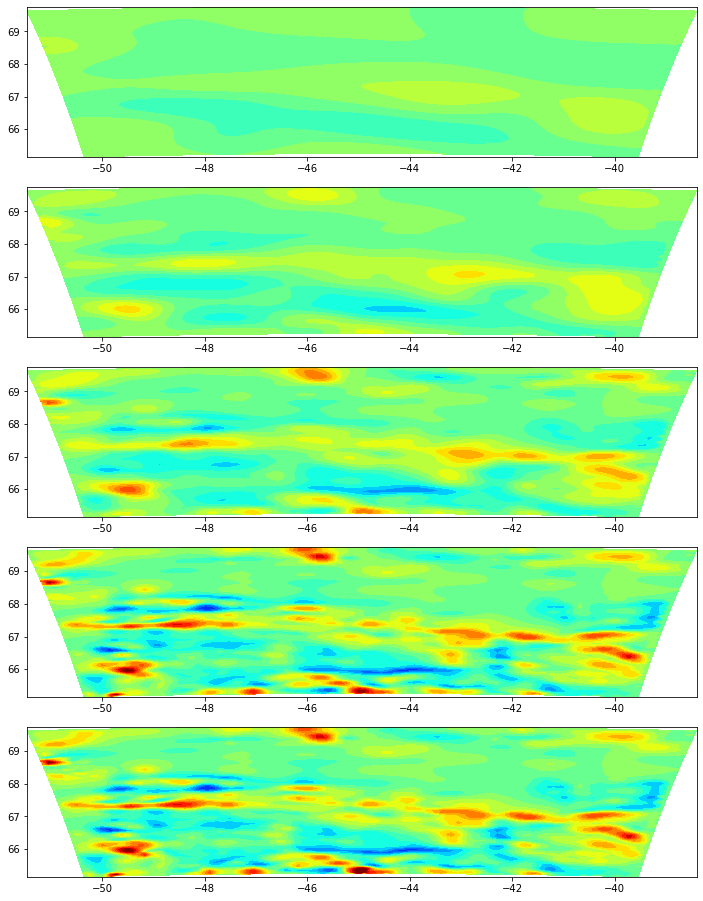

In [726]:
fig,axs = plt.subplots(len(spacings),1,figsize=(12,16))
for aux,ax in zip(auxiliary,axs):
    im = ax.contourf(lona,lata,aux[...,3],levels=np.linspace(-400,400,21),extend='both',cmap=plt.cm.jet)

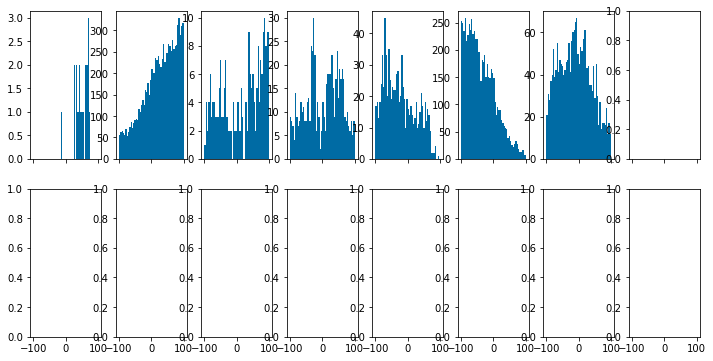

In [731]:
misfit = predicted[0] - aeromag[:,3]
yearly_mean = np.zeros(len(np.unique(years)))
year_shift = np.zeros(aeromag.shape[0])
fig,axs = plt.subplots(2,8,figsize=(12,6),sharex=True)
axs = axs.flatten()
for i,y in enumerate(np.unique(years)):
    yearly_mean[i] = misfit[years==y].mean()
    year_shift[years==y] = yearly_mean[i]
    axs[i].hist(misfit[years==y],np.linspace(-100,100,51))

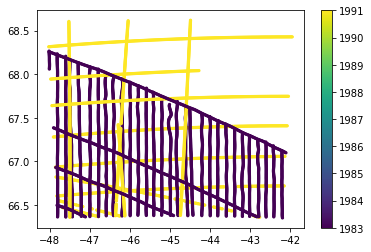

In [652]:
plt.scatter(aeromag[:,0],aeromag[:,1],5,years)
plt.colorbar()

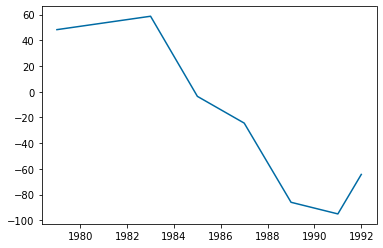

In [732]:
plt.plot(np.unique(years),yearly_mean)

### Stupid yearly stupid

In [662]:
multi_res_results = []
spacing = 16e3
repetitions = 4
aeromag_reduced = aeromag.copy()
yearly_means = np.zeros((repetitions,len(np.unique(years))))

for k in range(repetitions):
    multi_res_results.append(eq_run_extend(spacing,aeromag_reduced,aux_spacing=5000,height_factor=2,
                                           block_factor=15,lambda_d=0.5))
    ## Apply yearly shift
    misfit = aeromag_reduced[:,3] - prelim[2]
    year_shift = np.zeros(aeromag.shape[0])
    for i,y in enumerate(np.unique(years)):
        yearly_means[k,i] = misfit[years==y].mean()
        year_shift[years==y] = yearly_means[k,i]
    aeromag_reduced[:,3] = aeromag_reduced[:,3] - year_shift

98.39429755646852
71.28324879305568
71.28324879305568
71.28324879305568


### Block stat analysis
Analyse statistics for each block -> Does it make sense, to use it at this resolution?

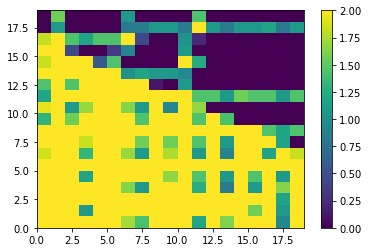

In [703]:
block_definition,station_count,dipole_count = block_analysis(aeromag,4e3,3.3)
plt.pcolormesh(station_count/dipole_count,vmin=0,vmax=2)
plt.colorbar()